**Import Libraries**

In [1]:
pip install lightly mambavision transformers mamba_ssm timm byol-pytorch

  Using cached mambavision-1.0.9-py3-none-any.whl.metadata (13 kB)
  Using cached timm-0.9.0-py3-none-any.whl.metadata (68 kB)
  Using cached mamba_ssm-1.0.1.tar.gz (28 kB)
  Preparing metadata (setup.py) ... done
  Using cached causal_conv1d-1.0.2.tar.gz (6.4 kB)
  Preparing metadata (setup.py) ... done
  Using cached buildtools-1.0.6-py3-none-any.whl
  Using cached sqlalchemy-2.0.39-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.6 kB)
  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached twisted-24.11.0-py3-none-any.whl.metadata (20 kB)
  Using cached simplejson-3.20.1-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.2 kB)
  Using cached furl-2.1.4-py2.py3-none-any.whl.metadata (25 kB)
  Using cached docopt-0.6.2-py2.py3-none-any.whl
  Using cached redo-3.0.0-py2.py3-none-any.whl.metadata (8.0 kB)
  Using cached orderedmultidict-1.0.1-py2.py3-none-any.whl.metadata (1.3 k

In [2]:
# Standard Libraries
import os
import copy
import random
from glob import glob
from PIL import Image

# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt

# Progress Bar
from tqdm import tqdm

# Machine Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, f1_score

# Hugging Face transformers to load the MambaVision model
from transformers import AutoModel

# BYOL library
from byol_pytorch import BYOL

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Define Parameters**

In [3]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

# Define parameters
SEED = 42
NUM_WORKERS =32

# Parameters BYOL pre-training
EPOCHS_BYOL = 100

# Parameteres training
LEARNING_RATE = 0.01
LEARNING_RATE_FINE_TUNING = 0.0001
EPOCHS = 12
BATCH_SIZE = 32
LEARNING_RATE_SCHEDULER_PATIENCE = 3
EARLY_STOPPING_PATIENCE = 5
OPTIMIZER_STEP_SIZE = 1
OPTIMIZER_GAMMA = 0.5

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Set Seed for Reproducibility**

In [4]:
def seed_everything(seed=SEED):
    """
    Sets the seed to ensure reproducibility.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Apply the seed
seed_everything()

# **Step 1: Load Data**

In [5]:
def extract_data(zip_path, extracted_path):
    """
    Extracts the ZIP file of the dataset.
    """
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    print(f"Data extracted to {extracted_path}")

# Uncomment the line below to extract data (if not already extracted)
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing**

In [6]:
# Define Disease Labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

def load_labels(csv_path, image_path):
    """
    Loads and preprocesses the labels from the CSV file.
    Maps each image to its corresponding file path and binary labels for each disease.
    """

    # Read the CSV file containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

    # Create a binary column for 'No Finding'
    labels_df['No_Finding'] = labels_df['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

    # Map image filenames to their full paths
    image_paths = glob(os.path.join(image_path, '**', 'images', '*.png'), recursive=True)
    img_path_dict = {os.path.basename(path): path for path in image_paths}

    # Add the full image path to the dataframe
    labels_df['Path'] = labels_df['Image Index'].map(img_path_dict)
    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')

# Load and preprocess the labels
labels_df = load_labels(labels_csv_path, EXTRACTED_PATH)

**Split Dataset**

In [7]:
# Split based on patients
unique_patients = labels_df['Patient ID'].unique()

# Split patients into training, validation and test sets
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED
)
train_patients, val_patients = train_test_split(
    train_val_patients, test_size=0.125, random_state=SEED
)

# Create dataframes for training, validation, and test sets
train_df = labels_df[labels_df['Patient ID'].isin(train_patients)].reset_index(drop=True)
val_df = labels_df[labels_df['Patient ID'].isin(val_patients)].reset_index(drop=True)
test_df = labels_df[labels_df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 78614
Validation size: 11212
Test size: 22294


**Define Dataset for Chest X-ray images**

In [8]:
class ChestXrayDataset(Dataset):
    """
    Custom Dataset for Chest X-ray images.
    """
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path and labels
        img_path = self.df.iloc[idx]['Path']
        image = plt.imread(img_path)
        label = self.df.iloc[idx][disease_labels].values.astype(np.float32)
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
        
        return image, label

**Define Data Transformations**

In [9]:
# Define transformations for training data
train_transforms = transforms.Compose([

    # Convert image to PIL format for further transformations
    transforms.ToPILImage(),

    # Convert to grayscale and change to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224, 224)),

    # Apply random horizontal flip to augment the data
    transforms.RandomHorizontalFlip(),

    # Randomly rotate the image within a range of ±10 degrees
    transforms.RandomRotation(10),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Define transformations for test data
test_transforms = transforms.Compose([

    # Convert image to PIL format for further transformations
    transforms.ToPILImage(),

    # Convert to grayscale and change to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224, 224)),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

**Create Datasets**

In [10]:
train_dataset = ChestXrayDataset(train_df, transform=train_transforms)
val_dataset = ChestXrayDataset(val_df, transform=test_transforms)
test_dataset = ChestXrayDataset(test_df, transform=test_transforms)

**Create DataLoaders**

In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# **Step 3: BYOL Pre-training**

In [12]:
backbone = AutoModel.from_pretrained("nvidia/MambaVision-T2-1K", trust_remote_code=True)
backbone.to(device)

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


MambaVisionModel(
  (model): MambaVision(
    (patch_embed): PatchEmbed(
      (proj): Identity()
      (conv_down): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(32, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (4): BatchNorm2d(80, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (levels): ModuleList(
      (0): MambaVisionLayer(
        (blocks): ModuleList(
          (0): ConvBlock(
            (conv1): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): GELU(approximate='tanh')
            (conv2): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm

In [13]:
learner = BYOL(
    backbone,
    image_size=224,
    hidden_layer = 'model.avgpool'
)

optimizer = optim.Adam(learner.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

best_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(EPOCHS_BYOL):
    epoch_loss = 0.0
    batch_count = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS_BYOL}")
    for batch in progress_bar:
        images = batch[0].to(device)
        loss = learner(images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        learner.update_moving_average()
        
        # Update tracking variables
        epoch_loss += loss.item()
        batch_count += 1
        progress_bar.set_postfix({"Loss": loss.item()})
    
    avg_loss = epoch_loss / batch_count
    print(f"Epoch {epoch+1} average loss: {avg_loss:.4f}")
    
    # Update the learning rate scheduler with the average loss
    scheduler.step(avg_loss)
    
    # Early stopping check
    if avg_loss < best_loss:
        best_loss = avg_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= EARLY_STOPPING_PATIENCE:
            print(f"No improvement for {EARLY_STOPPING_PATIENCE} consecutive epochs. Early stopping...")
            break

Epoch 1/100:   8%|▊         | 204/2457 [00:44<07:34,  4.95it/s, Loss=0.654] 

Epoch 1/100: 100%|██████████| 2457/2457 [04:50<00:00,  8.46it/s, Loss=0.0266] 


Epoch 1 average loss: 0.2400


Epoch 2/100: 100%|██████████| 2457/2457 [04:07<00:00,  9.91it/s, Loss=0.0206] 


Epoch 2 average loss: 0.1281


Epoch 3/100: 100%|██████████| 2457/2457 [04:08<00:00,  9.91it/s, Loss=0.0983] 


Epoch 3 average loss: 0.1131


Epoch 4/100: 100%|██████████| 2457/2457 [04:08<00:00,  9.90it/s, Loss=0.109]  


Epoch 4 average loss: 0.1264


Epoch 5/100: 100%|██████████| 2457/2457 [04:08<00:00,  9.88it/s, Loss=0.0132] 


Epoch 5 average loss: 0.1195


Epoch 6/100: 100%|██████████| 2457/2457 [04:08<00:00,  9.90it/s, Loss=0.019]  


Epoch 6 average loss: 0.1222


Epoch 7/100: 100%|██████████| 2457/2457 [04:08<00:00,  9.90it/s, Loss=0.0149] 


Epoch 7 average loss: 0.0861


Epoch 8/100: 100%|██████████| 2457/2457 [04:08<00:00,  9.89it/s, Loss=0.151]  


Epoch 8 average loss: 0.0712


Epoch 9/100: 100%|██████████| 2457/2457 [04:08<00:00,  9.90it/s, Loss=0.0148] 


Epoch 9 average loss: 0.0694


Epoch 10/100: 100%|██████████| 2457/2457 [04:08<00:00,  9.89it/s, Loss=0.00415]


Epoch 10 average loss: 0.0633


Epoch 11/100: 100%|██████████| 2457/2457 [04:07<00:00,  9.94it/s, Loss=0.002]   


Epoch 11 average loss: 0.0624


Epoch 12/100: 100%|██████████| 2457/2457 [04:06<00:00,  9.97it/s, Loss=0.281]   


Epoch 12 average loss: 0.0602


Epoch 13/100: 100%|██████████| 2457/2457 [04:08<00:00,  9.91it/s, Loss=0.0149]  


Epoch 13 average loss: 0.0576


Epoch 14/100: 100%|██████████| 2457/2457 [04:08<00:00,  9.90it/s, Loss=0.00334] 


Epoch 14 average loss: 0.0577


Epoch 15/100: 100%|██████████| 2457/2457 [04:08<00:00,  9.90it/s, Loss=0.0119]  


Epoch 15 average loss: 0.0559


Epoch 16/100: 100%|██████████| 2457/2457 [04:09<00:00,  9.85it/s, Loss=0.173]   


Epoch 16 average loss: 0.0555


Epoch 17/100: 100%|██████████| 2457/2457 [04:08<00:00,  9.87it/s, Loss=0.0125]  


Epoch 17 average loss: 0.0531


Epoch 18/100: 100%|██████████| 2457/2457 [04:08<00:00,  9.89it/s, Loss=0.00285] 


Epoch 18 average loss: 0.0538


Epoch 19/100: 100%|██████████| 2457/2457 [04:08<00:00,  9.89it/s, Loss=0.00291] 


Epoch 19 average loss: 0.0543


Epoch 20/100: 100%|██████████| 2457/2457 [04:08<00:00,  9.88it/s, Loss=0.0066]  


Epoch 20 average loss: 0.0562


Epoch 21/100: 100%|██████████| 2457/2457 [04:08<00:00,  9.89it/s, Loss=0.00353] 


Epoch 21 average loss: 0.0483


Epoch 22/100: 100%|██████████| 2457/2457 [04:07<00:00,  9.92it/s, Loss=0.0079]  


Epoch 22 average loss: 0.0498


Epoch 23/100: 100%|██████████| 2457/2457 [04:08<00:00,  9.89it/s, Loss=0.00138] 


Epoch 23 average loss: 0.0531


Epoch 24/100: 100%|██████████| 2457/2457 [04:08<00:00,  9.90it/s, Loss=0.00358] 


Epoch 24 average loss: 0.0486


Epoch 25/100: 100%|██████████| 2457/2457 [04:08<00:00,  9.89it/s, Loss=0.00958] 


Epoch 25 average loss: 0.0506


Epoch 26/100: 100%|██████████| 2457/2457 [04:08<00:00,  9.89it/s, Loss=0.168]   


Epoch 26 average loss: 0.0467


Epoch 27/100: 100%|██████████| 2457/2457 [04:08<00:00,  9.90it/s, Loss=0.014]   


Epoch 27 average loss: 0.0461


Epoch 28/100: 100%|██████████| 2457/2457 [04:08<00:00,  9.88it/s, Loss=0.0831]  


Epoch 28 average loss: 0.0469


Epoch 29/100: 100%|██████████| 2457/2457 [04:08<00:00,  9.89it/s, Loss=0.00142] 


Epoch 29 average loss: 0.0492


Epoch 30/100: 100%|██████████| 2457/2457 [04:08<00:00,  9.87it/s, Loss=0.0101]  


Epoch 30 average loss: 0.0469


Epoch 31/100: 100%|██████████| 2457/2457 [04:08<00:00,  9.89it/s, Loss=0.047]   


Epoch 31 average loss: 0.0482


Epoch 32/100: 100%|██████████| 2457/2457 [04:09<00:00,  9.86it/s, Loss=0.113]   

Epoch 32 average loss: 0.0488
No improvement for 5 consecutive epochs. Early stopping...


# **Step 4: Build the Model**

**Initialize the Multi-Label Classifier Model**

In [14]:
# Define the model
class MultiLabelClassifier(nn.Module):
    """
    Multi-Label Classification Model using Swin Transformer as the base model.
    """
    def __init__(self, backbone, num_classes=len(disease_labels)):
        super(MultiLabelClassifier, self).__init__()

        # Load pre-trained Vision Mamba model
        self.base_model = backbone

        print(self.base_model)

        # Replace the classification head to match the number of disease labels
        self.base_model.model.head = nn.Linear(self.base_model.model.head.in_features, num_classes)

    def forward(self, x):
        avg_pool, _ = self.base_model(x)
        return self.base_model.model.head(avg_pool)

# Initialize the Model
model = MultiLabelClassifier(backbone)
model.to(device)

MambaVisionModel(
  (model): MambaVision(
    (patch_embed): PatchEmbed(
      (proj): Identity()
      (conv_down): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(32, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (4): BatchNorm2d(80, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (levels): ModuleList(
      (0): MambaVisionLayer(
        (blocks): ModuleList(
          (0): ConvBlock(
            (conv1): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): GELU(approximate='tanh')
            (conv2): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm

MultiLabelClassifier(
  (base_model): MambaVisionModel(
    (model): MambaVision(
      (patch_embed): PatchEmbed(
        (proj): Identity()
        (conv_down): Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(32, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (4): BatchNorm2d(80, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
      )
      (levels): ModuleList(
        (0): MambaVisionLayer(
          (blocks): ModuleList(
            (0): ConvBlock(
              (conv1): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (norm1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (act1): GELU(approximate='tanh')
              (conv2): Conv2

**Use Multiple GPUs**

In [15]:
model = nn.DataParallel(model)

# **Step 5: Train the Model**

**Step 1: Train Classification Head Only**

In [16]:
# Freeze the backbone parameters
for name, param in model.named_parameters():
    if "head" not in name:
        param.requires_grad = False

In [17]:
# Only the classifier parameters will be updated
optimizer_head = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer_head, step_size=OPTIMIZER_STEP_SIZE, gamma=OPTIMIZER_GAMMA)

In [18]:
def train_model(model, train_loader, val_loader, criterion, optimizer, patience, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # List to store loss and AUC
    train_losses = []
    val_losses = []
    val_aucs = []

    # Early stopping parameters
    best_score = 0
    epochs_without_improvement = 0

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Apply sigmoid
                preds = torch.sigmoid(outputs).cpu()

                # Store predictions and true labels
                all_preds.append(preds)
                all_labels.append(labels.cpu())
                
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Concatenate all batches
        preds = torch.cat(all_preds)
        labels = torch.cat(all_labels)
    
        roc_auc_per_label = []

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Calculate ROC AUC
            roc_auc = roc_auc_score(labels[:, i].numpy(), preds[:, i].numpy())
            roc_auc_per_label.append(roc_auc)

        # Calculate and add overall metrics
        mean_auc = np.mean(roc_auc_per_label)
        val_aucs.append(mean_auc)

        # Update the scheduler once per epoch.
        scheduler.step()
        
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f} | Mean Validation AUC: {mean_auc:.4f}")

        # Early stopping
        if mean_auc > best_score:
            best_score = mean_auc
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model.pt')
            print(f"New best model saved with Mean Validation AUC: {mean_auc:.4f}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping. No improvement for {patience} epochs")
                model.load_state_dict(torch.load('best_model.pt', weights_only=True))
                break

    return train_losses, val_losses, val_aucs

# Train the model for the desired number of epochs
train_losses, val_losses, val_aucs = train_model(model, train_loader, val_loader, criterion, optimizer_head, LEARNING_RATE_SCHEDULER_PATIENCE, EPOCHS)

Epoch 1/12: 100%|██████████| 351/351 [00:20<00:00, 16.90it/s, Loss=0.21]  


Epoch 1/12 | Training Loss: 0.2230 | Validation Loss: 0.1858 | Mean Validation AUC: 0.6019
New best model saved with Mean Validation AUC: 0.6019


Epoch 2/12: 100%|██████████| 351/351 [00:10<00:00, 34.35it/s, Loss=0.162] 


Epoch 2/12 | Training Loss: 0.1951 | Validation Loss: 0.1828 | Mean Validation AUC: 0.6172
New best model saved with Mean Validation AUC: 0.6172


Epoch 3/12: 100%|██████████| 351/351 [00:10<00:00, 34.79it/s, Loss=0.189] 


Epoch 3/12 | Training Loss: 0.1868 | Validation Loss: 0.1796 | Mean Validation AUC: 0.6203
New best model saved with Mean Validation AUC: 0.6203


Epoch 4/12: 100%|██████████| 351/351 [00:10<00:00, 34.51it/s, Loss=0.164] 


Epoch 4/12 | Training Loss: 0.1824 | Validation Loss: 0.1769 | Mean Validation AUC: 0.6419
New best model saved with Mean Validation AUC: 0.6419


Epoch 5/12: 100%|██████████| 351/351 [00:09<00:00, 35.19it/s, Loss=0.163] 


Epoch 5/12 | Training Loss: 0.1802 | Validation Loss: 0.1760 | Mean Validation AUC: 0.6440
New best model saved with Mean Validation AUC: 0.6440


Epoch 6/12: 100%|██████████| 351/351 [00:10<00:00, 34.69it/s, Loss=0.161] 


Epoch 6/12 | Training Loss: 0.1790 | Validation Loss: 0.1757 | Mean Validation AUC: 0.6497
New best model saved with Mean Validation AUC: 0.6497


Epoch 7/12: 100%|██████████| 351/351 [00:10<00:00, 34.65it/s, Loss=0.161] 


Epoch 7/12 | Training Loss: 0.1784 | Validation Loss: 0.1750 | Mean Validation AUC: 0.6502
New best model saved with Mean Validation AUC: 0.6502


Epoch 8/12: 100%|██████████| 351/351 [00:10<00:00, 34.94it/s, Loss=0.159] 


Epoch 8/12 | Training Loss: 0.1781 | Validation Loss: 0.1750 | Mean Validation AUC: 0.6506
New best model saved with Mean Validation AUC: 0.6506


Epoch 9/12: 100%|██████████| 351/351 [00:10<00:00, 34.75it/s, Loss=0.156] 


Epoch 9/12 | Training Loss: 0.1780 | Validation Loss: 0.1750 | Mean Validation AUC: 0.6515
New best model saved with Mean Validation AUC: 0.6515


Epoch 10/12: 100%|██████████| 351/351 [00:10<00:00, 34.37it/s, Loss=0.157] 


Epoch 10/12 | Training Loss: 0.1778 | Validation Loss: 0.1747 | Mean Validation AUC: 0.6529
New best model saved with Mean Validation AUC: 0.6529


Epoch 11/12: 100%|██████████| 351/351 [00:10<00:00, 34.62it/s, Loss=0.157] 


Epoch 11/12 | Training Loss: 0.1779 | Validation Loss: 0.1748 | Mean Validation AUC: 0.6524


Epoch 12/12: 100%|██████████| 351/351 [00:10<00:00, 33.82it/s, Loss=0.157] 


Epoch 12/12 | Training Loss: 0.1778 | Validation Loss: 0.1748 | Mean Validation AUC: 0.6528


**Step 2: Fine Tune Entire Network**

In [19]:
# Unfreeze all layers for fine tuning
for param in model.parameters():
    param.requires_grad = True

In [20]:
# Use a lower learning rate for the whole network
optimizer_full = optim.Adam(model.parameters(), lr=LEARNING_RATE_FINE_TUNING)
scheduler = optim.lr_scheduler.StepLR(optimizer_full, step_size=OPTIMIZER_STEP_SIZE, gamma=OPTIMIZER_GAMMA)

In [21]:
def train_model(model, train_loader, val_loader, criterion, optimizer, patience, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # List to store loss and AUC
    train_losses = []
    val_losses = []
    val_aucs = []

    # Early stopping parameters
    best_score = 0
    epochs_without_improvement = 0

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Apply sigmoid
                preds = torch.sigmoid(outputs).cpu()

                # Store predictions and true labels
                all_preds.append(preds)
                all_labels.append(labels.cpu())
                
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Concatenate all batches
        preds = torch.cat(all_preds)
        labels = torch.cat(all_labels)
    
        roc_auc_per_label = []

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Calculate ROC AUC
            roc_auc = roc_auc_score(labels[:, i].numpy(), preds[:, i].numpy())
            roc_auc_per_label.append(roc_auc)

        # Calculate and add overall metrics
        mean_auc = np.mean(roc_auc_per_label)
        val_aucs.append(mean_auc)
        
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f} | Mean Validation AUC: {mean_auc:.4f}")

        # Update the scheduler once per epoch.
        scheduler.step()

        # Early stopping
        if mean_auc > best_score:
            best_score = mean_auc
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model.pt')
            print(f"New best model saved with Mean Validation AUC: {mean_auc:.4f}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping. No improvement for {patience:.4f} epochs")
                model.load_state_dict(torch.load('best_model.pt', weights_only=True))
                break

    return train_losses, val_losses, val_aucs

# Train the model for the desired number of epochs
train_losses, val_losses, val_aucs = train_model(model, train_loader, val_loader, criterion, optimizer_full, LEARNING_RATE_SCHEDULER_PATIENCE, EPOCHS)

Epoch 1/12: 100%|██████████| 351/351 [00:10<00:00, 34.15it/s, Loss=0.134] 


Epoch 1/12 | Training Loss: 0.1717 | Validation Loss: 0.1737 | Mean Validation AUC: 0.7612
New best model saved with Mean Validation AUC: 0.7612


Epoch 2/12: 100%|██████████| 351/351 [00:10<00:00, 34.60it/s, Loss=0.146] 


Epoch 2/12 | Training Loss: 0.1617 | Validation Loss: 0.1597 | Mean Validation AUC: 0.7789
New best model saved with Mean Validation AUC: 0.7789


Epoch 3/12: 100%|██████████| 351/351 [00:10<00:00, 34.90it/s, Loss=0.127] 


Epoch 3/12 | Training Loss: 0.1578 | Validation Loss: 0.1534 | Mean Validation AUC: 0.7937
New best model saved with Mean Validation AUC: 0.7937


Epoch 4/12: 100%|██████████| 351/351 [00:10<00:00, 34.57it/s, Loss=0.13]  


Epoch 4/12 | Training Loss: 0.1556 | Validation Loss: 0.1517 | Mean Validation AUC: 0.7982
New best model saved with Mean Validation AUC: 0.7982


Epoch 5/12: 100%|██████████| 351/351 [00:10<00:00, 34.64it/s, Loss=0.131] 


Epoch 5/12 | Training Loss: 0.1546 | Validation Loss: 0.1512 | Mean Validation AUC: 0.8018
New best model saved with Mean Validation AUC: 0.8018


Epoch 6/12: 100%|██████████| 351/351 [00:10<00:00, 34.17it/s, Loss=0.132] 


Epoch 6/12 | Training Loss: 0.1540 | Validation Loss: 0.1510 | Mean Validation AUC: 0.8031
New best model saved with Mean Validation AUC: 0.8031


Epoch 7/12: 100%|██████████| 351/351 [00:10<00:00, 34.11it/s, Loss=0.131] 


Epoch 7/12 | Training Loss: 0.1539 | Validation Loss: 0.1508 | Mean Validation AUC: 0.8033
New best model saved with Mean Validation AUC: 0.8033


Epoch 8/12: 100%|██████████| 351/351 [00:10<00:00, 34.60it/s, Loss=0.131] 


Epoch 8/12 | Training Loss: 0.1537 | Validation Loss: 0.1508 | Mean Validation AUC: 0.8037
New best model saved with Mean Validation AUC: 0.8037


Epoch 9/12: 100%|██████████| 351/351 [00:10<00:00, 34.13it/s, Loss=0.13]  


Epoch 9/12 | Training Loss: 0.1537 | Validation Loss: 0.1508 | Mean Validation AUC: 0.8034


Epoch 10/12: 100%|██████████| 351/351 [00:10<00:00, 34.08it/s, Loss=0.131] 


Epoch 10/12 | Training Loss: 0.1537 | Validation Loss: 0.1507 | Mean Validation AUC: 0.8037
New best model saved with Mean Validation AUC: 0.8037


Epoch 11/12: 100%|██████████| 351/351 [00:10<00:00, 34.26it/s, Loss=0.13]  


Epoch 11/12 | Training Loss: 0.1537 | Validation Loss: 0.1508 | Mean Validation AUC: 0.8034


Epoch 12/12: 100%|██████████| 351/351 [00:10<00:00, 34.37it/s, Loss=0.13]  


Epoch 12/12 | Training Loss: 0.1539 | Validation Loss: 0.1508 | Mean Validation AUC: 0.8034


# **Step 6: Evaluate the Model**

In [22]:
# TTA transforms
tta_transforms = [
    lambda img: img,
    lambda img: transforms.RandomHorizontalFlip(p=1.0)(img),
    lambda img: transforms.RandomRotation(10)(img)
]

In [23]:
def evaluate_model(model, test_loader):
    """
    Evaluates the model on the test set and returns predictions and true labels.
    """
    model.eval()
    all_preds = []
    all_labels = []

    # Progress bar
    progress_bar = tqdm(test_loader, desc="Evaluating on Test Set")

    # Disable gradients for evaluation
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)

            tta_preds = []
            
            # Apply each TTA transformation and predict
            for tta in tta_transforms:
                augmented_inputs = tta(inputs)
                outputs = model(augmented_inputs)
                preds = torch.sigmoid(outputs)
                tta_preds.append(preds)

            # Average the predictions across TTA transforms
            avg_preds = torch.stack(tta_preds).mean(dim=0).cpu()

            # Store predictions and true labels
            all_preds.append(avg_preds)
            all_labels.append(labels)

    # Concatenate all batches
    preds = torch.cat(all_preds)
    labels = torch.cat(all_labels)
    return preds, labels

# Get predictions and true labels
preds, labels = evaluate_model(model, test_loader)

Evaluating on Test Set:   0%|          | 0/697 [00:00<?, ?it/s]

Evaluating on Test Set: 100%|██████████| 697/697 [00:35<00:00, 19.59it/s]


**Compute Metrics for Each Label**

In [24]:
# Initialize dictionaries for metrics
accuracy_per_label = {}
f1_per_label = {}
roc_auc_per_label = {}

# Compute metrics for each label
for i, label in enumerate(disease_labels):
    
    # Binarize predictions with threshold 0.5
    binary_preds = preds[:, i] > 0.5

    # Calculate accuracy
    acc = accuracy_score(labels[:, i], binary_preds)

    # Calculate f1 score
    f1 = f1_score(labels[:, i], binary_preds)

    # Calculate ROC AUC
    roc_auc = roc_auc_score(labels[:, i], preds[:, i])

    # Store metrics
    accuracy_per_label[label] = acc
    f1_per_label[label] = f1
    roc_auc_per_label[label] = roc_auc

# Create a DataFrame for metrics
metrics_df = pd.DataFrame({
    'Accuracy': accuracy_per_label,
    'F1 Score': f1_per_label,
    'ROC AUC': roc_auc_per_label
})

# Calculate the mean for all diseases
metrics_df.loc['Overall'] = metrics_df.mean()

# Print dataframe with metrics
metrics_df

,Accuracy,F1 Score,ROC AUC
Atelectasis,0.899973,0.057481,0.787304
Consolidation,0.957343,0.000000,0.797591
Infiltration,0.813403,0.101900,0.693013
Pneumothorax,0.953261,0.197227,0.835350
Edema,0.979636,0.000000,0.883869
Emphysema,0.976182,0.116473,0.859898
Fibrosis,0.983673,0.000000,0.750881
Effusion,0.893649,0.407694,0.865808
Pneumonia,0.986813,0.000000,0.721227
Pleural_Thickening,0.970396,0.000000,0.771036


**Plot ROC curves for each label**

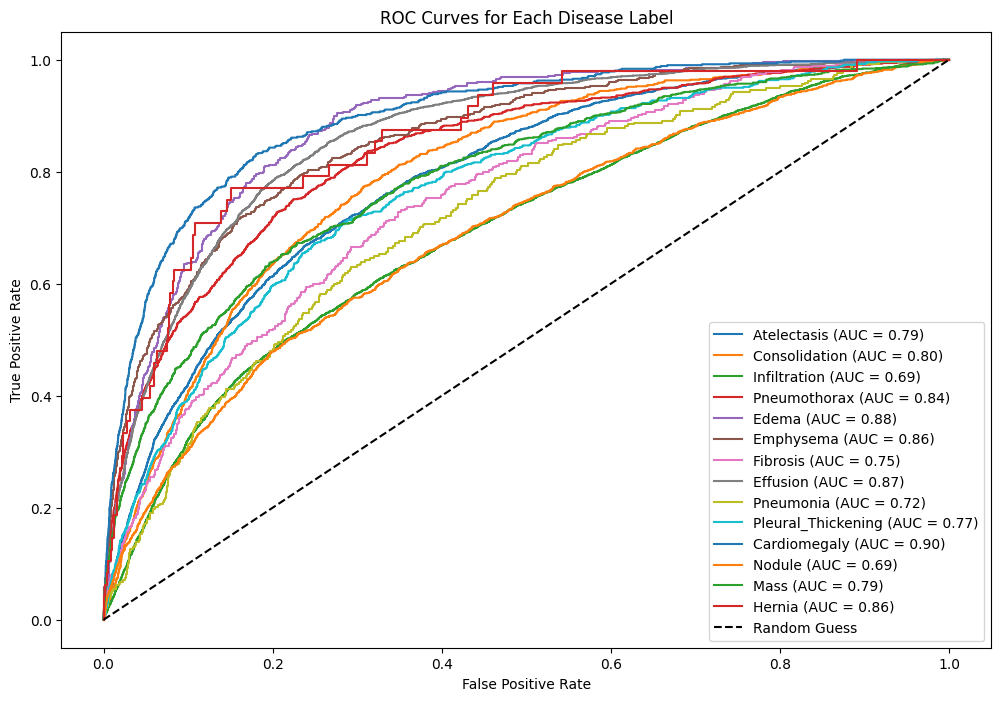

In [25]:
# Plot ROC curves
plt.figure(figsize=(12, 8))
for i, label in enumerate(disease_labels):
    fpr, tpr, _ = roc_curve(labels[:, i], preds[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc_per_label[label]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Disease Label')
plt.legend(loc='lower right')
plt.show()

**Plot Training and Validation Loss**

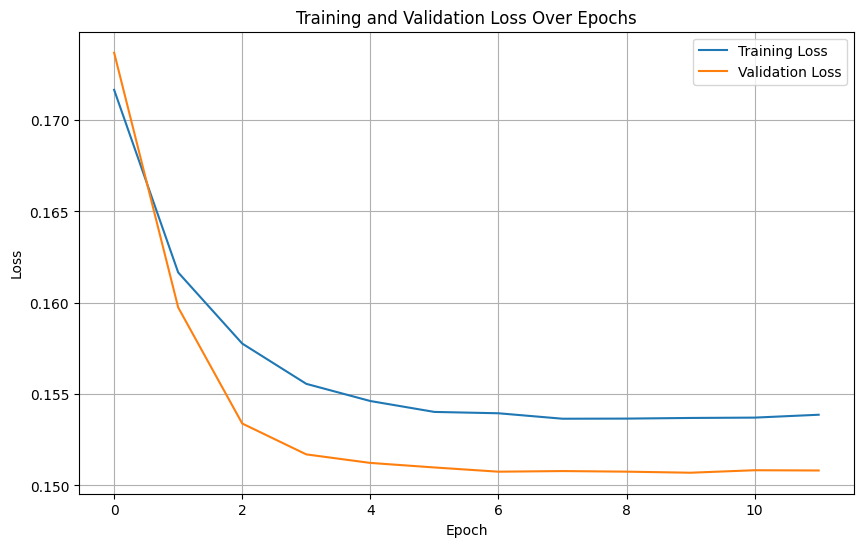

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Validation AUC**

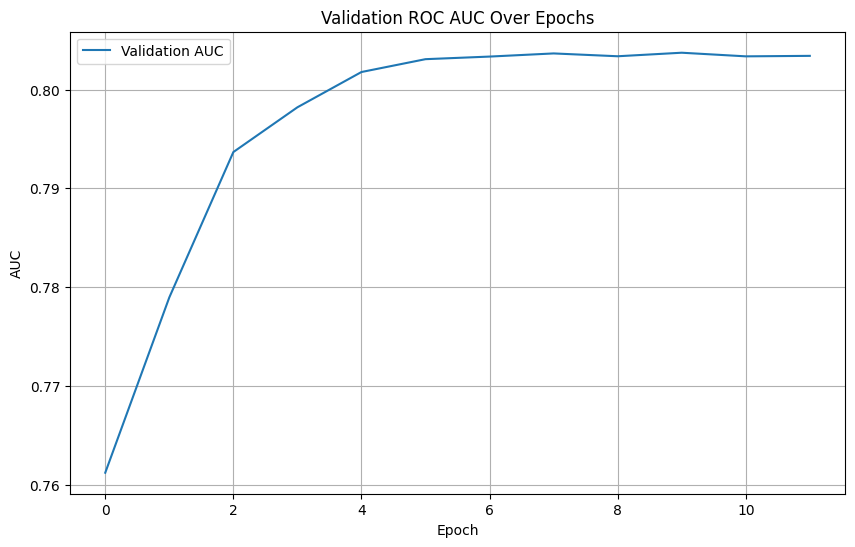

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(val_aucs, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation ROC AUC Over Epochs')
plt.legend()
plt.grid(True)
plt.show()